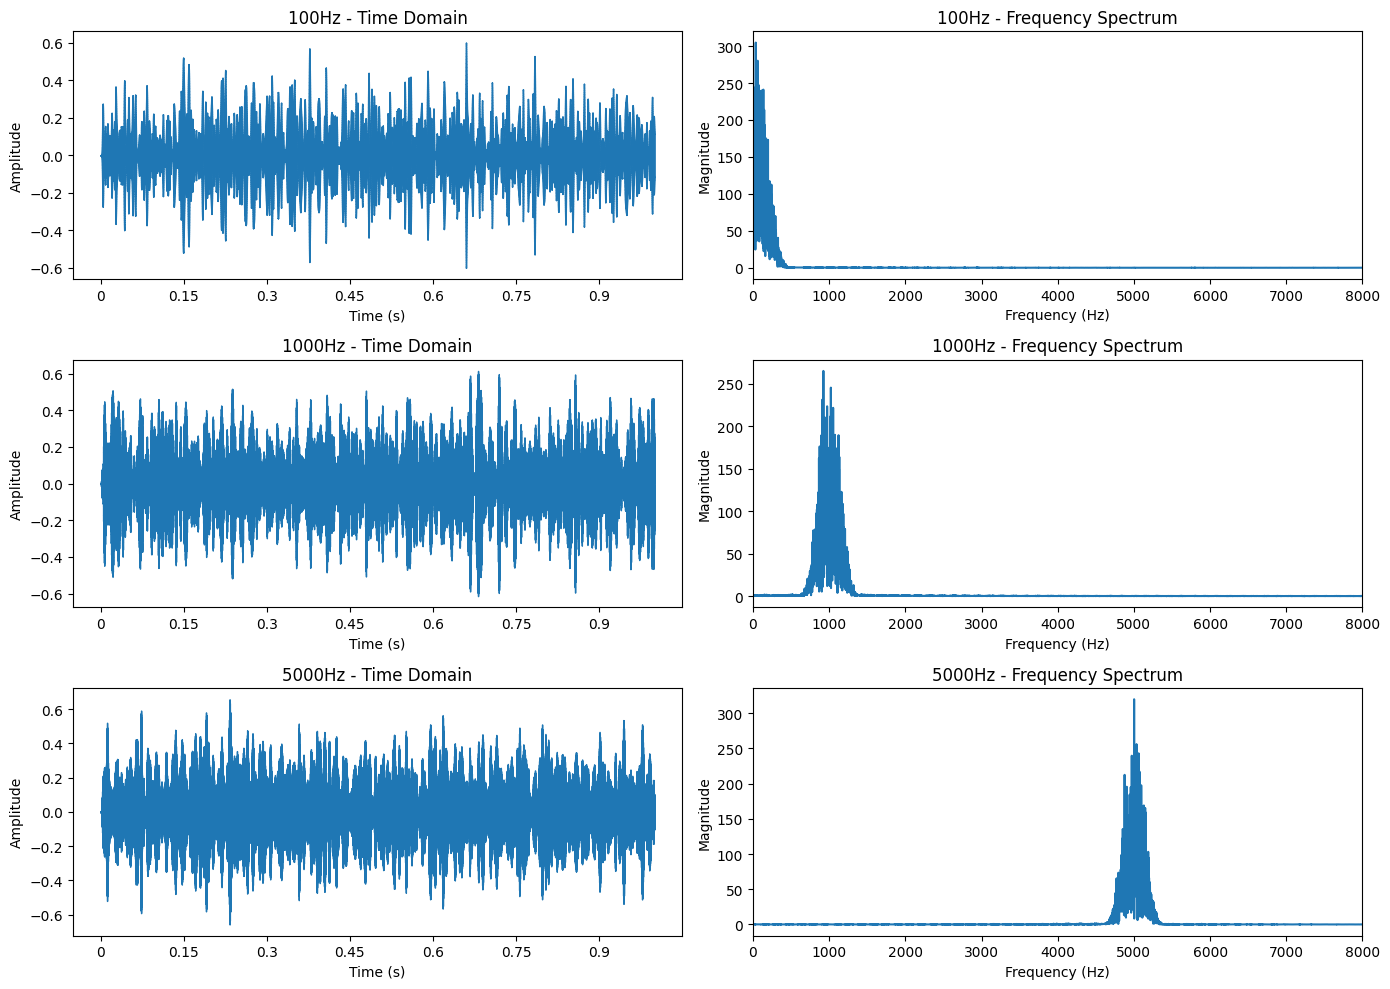

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, lfilter
import librosa
import librosa.display

# 1. 입력 신호 생성 (화이트 노이즈)
sr = 16000  # 샘플링 주파수
T = 1.0     # 1초
x = np.random.randn(int(sr * T))

# 2. 필터 설계 함수 -> convolution 연산에 사용할 kernel singal 정의
def design_bandpass_filter(center_hz, sr, width=100, numtaps=101):
    nyq = sr / 2
    low = max((center_hz - width) / nyq, 1e-4)
    high = min((center_hz + width) / nyq, 0.9999)
    if low >= high:
        raise ValueError(f"잘못된 주파수 범위: low={low*nyq}, high={high*nyq}")
    return firwin(numtaps, [low, high], pass_zero=False)

# 3. 필터 계수 생성 -> center 주파수와 sampling rate를 줘서 kernel singal 설계
filters = {
    "100Hz": design_bandpass_filter(100, sr),
    "1000Hz": design_bandpass_filter(1000, sr),
    "5000Hz": design_bandpass_filter(5000, sr)
}

# 4. 필터 적용  -> 입력 singal에 kernel singal convolution 연산 진행
outputs = {k: lfilter(h, [1], x) for k, h in filters.items()}

# 5. 시각화 (시간 + 주파수)
plt.figure(figsize=(14, 10))

for i, (label, y) in enumerate(outputs.items()):
    # 시간 영역
    plt.subplot(len(filters), 2, 2*i + 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"{label} - Time Domain")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    # 주파수 영역 (FFT)
    Y = np.abs(np.fft.rfft(y))
    freqs = np.fft.rfftfreq(len(y), d=1/sr)
    plt.subplot(len(filters), 2, 2*i + 2)
    plt.plot(freqs, Y)
    plt.title(f"{label} - Frequency Spectrum")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.xlim(0, 8000)  # Nyquist 제한

plt.tight_layout()
plt.show()

아래의 코드는 1 ~ 10까지 3회 녹음하고 그 내용을 CNN 을 이용해 학습한 후 모델을 저장하고 저장된 모델을 로딩해 추론하는 과정

In [3]:
# 필요 라이브러리
import os
from base64 import b64decode
from google.colab import output
from IPython.display import Audio

# 폴더 생성
os.makedirs("data", exist_ok=True)

# 녹음 함수
def record(label, idx):
    print(f"{label}을(를) 말하세요. ({idx}/3)")
    js = """
    const sleep = time => new Promise(resolve => setTimeout(resolve, time))
    const b2text = blob => new Promise(resolve => {
      const reader = new FileReader();
      reader.onloadend = () => resolve(reader.result.split(',')[1]);
      reader.readAsDataURL(blob);
    });
    async function record() {
      const stream = await navigator.mediaDevices.getUserMedia({ audio: true });
      const recorder = new MediaRecorder(stream);
      const chunks = [];
      recorder.ondataavailable = e => chunks.push(e.data);
      recorder.start();
      await sleep(2000);
      recorder.stop();
      await new Promise(resolve => recorder.onstop = resolve);
      const blob = new Blob(chunks);
      const base64 = await b2text(blob);
      return base64;
    }
    record();
    """
    audio = output.eval_js(js)
    binary = b64decode(audio)
    path = f"data/{label}_{idx}.wav"
    with open(path, 'wb') as f:
        f.write(binary)
    return path

# 숫자 1~10을 각 3회 녹음
for label in range(1, 11):
    for idx in range(1, 4):
        path = record(label, idx)
        print(f"Saved: {path}")

1을(를) 말하세요. (1/3)
Saved: data/1_1.wav
1을(를) 말하세요. (2/3)
Saved: data/1_2.wav
1을(를) 말하세요. (3/3)
Saved: data/1_3.wav
2을(를) 말하세요. (1/3)
Saved: data/2_1.wav
2을(를) 말하세요. (2/3)
Saved: data/2_2.wav
2을(를) 말하세요. (3/3)
Saved: data/2_3.wav
3을(를) 말하세요. (1/3)
Saved: data/3_1.wav
3을(를) 말하세요. (2/3)
Saved: data/3_2.wav
3을(를) 말하세요. (3/3)
Saved: data/3_3.wav
4을(를) 말하세요. (1/3)
Saved: data/4_1.wav
4을(를) 말하세요. (2/3)
Saved: data/4_2.wav
4을(를) 말하세요. (3/3)
Saved: data/4_3.wav
5을(를) 말하세요. (1/3)
Saved: data/5_1.wav
5을(를) 말하세요. (2/3)
Saved: data/5_2.wav
5을(를) 말하세요. (3/3)
Saved: data/5_3.wav
6을(를) 말하세요. (1/3)
Saved: data/6_1.wav
6을(를) 말하세요. (2/3)
Saved: data/6_2.wav
6을(를) 말하세요. (3/3)
Saved: data/6_3.wav
7을(를) 말하세요. (1/3)
Saved: data/7_1.wav
7을(를) 말하세요. (2/3)
Saved: data/7_2.wav
7을(를) 말하세요. (3/3)
Saved: data/7_3.wav
8을(를) 말하세요. (1/3)
Saved: data/8_1.wav
8을(를) 말하세요. (2/3)
Saved: data/8_2.wav
8을(를) 말하세요. (3/3)
Saved: data/8_3.wav
9을(를) 말하세요. (1/3)
Saved: data/9_1.wav
9을(를) 말하세요. (2/3)
Saved: data/9_2.wav
9을(를) 말하세요. 

In [7]:
import librosa
import numpy as np
import torch
from sklearn.model_selection import train_test_split

def extract_mfcc(file_path, max_len=32):
    y, sr = librosa.load(file_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    if mfcc.shape[1] < max_len:
        pad = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc

X, y = [], []
for file in os.listdir("data"):
    if file.endswith(".wav"):
        label = int(file.split("_")[0]) - 1  # 0~9
        mfcc = extract_mfcc(os.path.join("data", file))
        X.append(mfcc)
        y.append(label)

X = np.array(X)  # (N, 40, 32)
y = np.array(y)

# 텐서 변환
X = torch.tensor(X).unsqueeze(1).float()  # (N, 1, 40, 32)
y = torch.tensor(y).long()

# train/test 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

FileNotFoundError: [Errno 2] No such file or directory: 'data'

In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

class SpeechCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 10 * 8, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (16,20,16)
        x = self.pool(F.relu(self.conv2(x)))  # (32,10,8)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

model = SpeechCNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 학습
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=8, shuffle=True)

for epoch in range(20):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# 모델 저장
torch.save(model.state_dict(), "cnn_digit_model.pth")

NameError: name 'X_train' is not defined

In [45]:
# 새 입력 녹음
path = record("10", 0)
print("분류할 파일:", path)

# MFCC 추출
mfcc = extract_mfcc(path)
input_tensor = torch.tensor(mfcc).unsqueeze(0).unsqueeze(0).float()  # (1,1,40,32)

# 모델 불러오기
model = SpeechCNN()
model.load_state_dict(torch.load("cnn_digit_model.pth"))
model.eval()

# 예측
with torch.no_grad():
    output = model(input_tensor)
    pred = torch.argmax(output, dim=1).item()

print(f"예측 결과: {pred + 1}")

10을(를) 말하세요. (0/3)
분류할 파일: data/10_0.wav
예측 결과: 10


/tmp/ipython-input-4-3319909446.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=16000)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


RNN

In [10]:
import torch
import torch.nn as nn
import os
import librosa
import numpy as np
import torch
from sklearn.model_selection import train_test_split
# RNN 모델 정의
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, h_n = self.rnn(x)      # out: [batch, seq, hidden]
        out = self.fc(out[:, -1, :]) # 마지막 타임스텝만 출력
        return out

In [2]:
!mkdir -p gsc
%cd gsc
!wget -q https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz
!tar -xf speech_commands_v0.02.tar.gz
%cd ..

/content/gsc
/content


In [12]:
import random

import soundfile as sf
#음성 샘플 생성
digit_words = ['zero','one','two','three','four','five','six','seven','eight','nine']
src_root = "gsc"

# 이어붙인 연속 음성 샘플 생성
concat_dir = "gsc_concat"
os.makedirs(concat_dir, exist_ok=True)

samples = []
for i in range(200):
    digits = random.choices(digit_words, k=random.randint(3, 5))
    wavs = []
    for word in digits:
        folder = os.path.join(src_root, word)
        files = [f for f in os.listdir(folder) if f.endswith(".wav")]
        path = os.path.join(folder, random.choice(files))
        y, _ = librosa.load(path, sr=16000)
        wavs.append(y)
    full = np.concatenate(wavs)
    out_path = os.path.join(concat_dir, f"sample_{i}.wav")
    sf.write(out_path, full, 16000)
    samples.append((out_path, " ".join(digits)))

print("샘플 생성 완료:", len(samples))

샘플 생성 완료: 200


In [13]:
#전처리 및 데이터 준비
char_vocab = sorted(list("abcdefghijklmnopqrstuvwxyz '"))
char2idx = {ch: i for i, ch in enumerate(char_vocab)}
PAD_IDX = len(char2idx)
idx2char = {i: ch for ch, i in char2idx.items()}

def text_to_seq(text, max_len=100):
    seq = [char2idx[c] for c in text if c in char2idx]
    seq += [PAD_IDX] * (max_len - len(seq))
    return seq[:max_len]

def extract_mfcc(path, max_len=100):
    y, sr = librosa.load(path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    if mfcc.shape[1] < max_len:
        pad = np.zeros((13, max_len - mfcc.shape[1]))
        mfcc = np.concatenate((mfcc, pad), axis=1)
    return mfcc[:, :max_len].T  # [T, F]

X, y = [], []
for path, label in samples:
    X.append(extract_mfcc(path))
    y.append(text_to_seq(label))

X = np.array(X)
y = np.array(y)

In [14]:
#학습용 데이터로 변환
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

In [15]:
#RNN 모델 정의
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_dim=13, hidden_dim=128, output_dim=len(char2idx)+1):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.rnn(x)       # [B, T, H]
        out = self.fc(out)         # [B, T, V]
        return out

    def backward(self, loss):
        loss.backward()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch 1002: Loss=1.2288
Epoch 1003: Loss=1.2297
Epoch 1004: Loss=1.2252
Epoch 1005: Loss=1.2256
Epoch 1006: Loss=1.2252
Epoch 1007: Loss=1.2196
Epoch 1008: Loss=1.2215
Epoch 1009: Loss=1.2292
Epoch 1010: Loss=1.2248
Epoch 1011: Loss=1.2190
Epoch 1012: Loss=1.2123
Epoch 1013: Loss=1.2137
Epoch 1014: Loss=1.2142
Epoch 1015: Loss=1.2157
Epoch 1016: Loss=1.2135
Epoch 1017: Loss=1.2045
Epoch 1018: Loss=1.2070
Epoch 1019: Loss=1.2097
Epoch 1020: Loss=1.2052
Epoch 1021: Loss=1.2050
Epoch 1022: Loss=1.2023
Epoch 1023: Loss=1.2119
Epoch 1024: Loss=1.2122
Epoch 1025: Loss=1.2282
Epoch 1026: Loss=1.2209
Epoch 1027: Loss=1.2332
Epoch 1028: Loss=1.2250
Epoch 1029: Loss=1.2187
Epoch 1030: Loss=1.2181
Epoch 1031: Loss=1.2155
Epoch 1032: Loss=1.2084
Epoch 1033: Loss=1.2041
Epoch 1034: Loss=1.2049
Epoch 1035: Loss=1.2064
Epoch 1036: Loss=1.2004
Epoch 1037: Loss=1.2159
Epoch 1038: Loss=1.2040
Epoch 1039: Loss=1.2024
Epoch 1040: Loss=1.2030
Epoch 1041: Loss=1.3241
Epoc

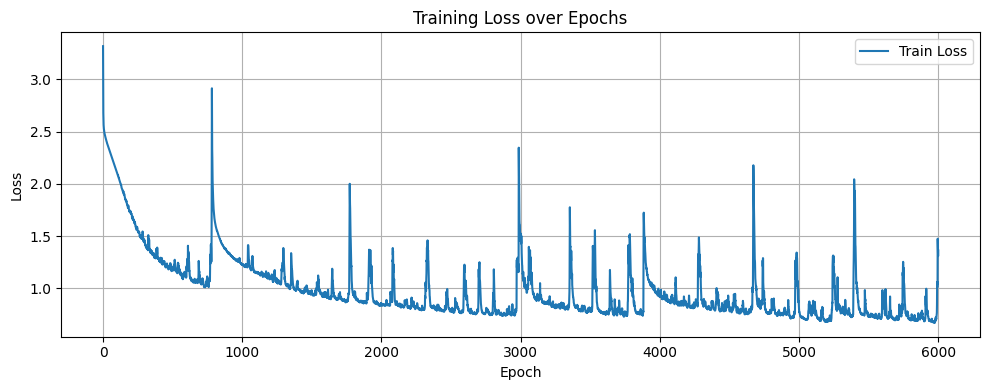

In [19]:
#모델 학습
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNNModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

loss_history = []  # 손실 저장용 리스트

for epoch in range(6000):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)                    # [B, T, V]
        pred = pred.view(-1, pred.shape[-1])
        yb = yb.view(-1)
        loss = criterion(pred, yb)
        model.backward(loss)
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}")

# 모델 저장
torch.save(model.state_dict(), "rnn_speech_model.pth")
print("모델 저장 완료: rnn_speech_model.pth")

# 손실 함수 그래프 출력
plt.figure(figsize=(10, 4))
plt.plot(loss_history, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
#추론 및 오디오 재생함수 정의
from IPython.display import Audio, display

def load_model_for_inference(model_path="rnn_speech_model.pth"):
    model = RNNModel().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def infer_and_play_audio(sample_path, label_text=None, model_path="rnn_speech_model.pth"):
    # 오디오 재생
    print(f"[음성 재생]: {sample_path}")
    display(Audio(sample_path))

    # 모델 로드
    model = load_model_for_inference(model_path)

    # 입력 전처리
    mfcc = extract_mfcc(sample_path)
    x = torch.tensor(mfcc, dtype=torch.float32).unsqueeze(0).to(device)  # [1, T, F]

    # 추론
    with torch.no_grad():
        output = model(x)  # [1, T, V]
        pred_idx = output.argmax(2)[0]
        pred_text = ''.join([idx2char[i.item()] for i in pred_idx if i.item() != PAD_IDX])

    # 출력
    if label_text:
        print("[정답 문장]:", label_text)
    print("[모델 예측]:", pred_text)


In [21]:
#추론(추론은 데이터셋의 음성파일을 입력으로 사용)
# 학습에 사용된 샘플 중 하나로 테스트
sample_path, label = samples[5]
infer_and_play_audio(sample_path, label_text=label)

[음성 재생]: gsc_concat/sample_5.wav


[정답 문장]: nine four five six zero
[모델 예측]: nonennnun n neeo shrerr teroennn e   fex eo  eene ghrhnohhheeeeunr eerorir e onure   e         t    


LSTM

In [22]:
# Google Speech Commands 데이터 다운로드
!mkdir -p gsc
%cd gsc
!wget -q https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz
!tar -xf speech_commands_v0.02.tar.gz
%cd ..

/content/gsc
/content


In [23]:
import os, random
import numpy as np
import librosa
import soundfile as sf

digit_words = ['zero','one','two','three','four','five','six','seven','eight','nine']
src_root = "gsc"
concat_dir = "gsc_concat"
os.makedirs(concat_dir, exist_ok=True)

samples = []
for i in range(200):
    digits = random.choices(digit_words, k=random.randint(3, 5))
    wavs = []
    for word in digits:
        folder = os.path.join(src_root, word)
        files = [f for f in os.listdir(folder) if f.endswith(".wav")]
        path = os.path.join(folder, random.choice(files))
        y, _ = librosa.load(path, sr=16000)
        wavs.append(y)
    full = np.concatenate(wavs)
    out_path = os.path.join(concat_dir, f"sample_{i}.wav")
    sf.write(out_path, full, 16000)
    samples.append((out_path, " ".join(digits)))
print("샘플 생성 완료:", len(samples))

샘플 생성 완료: 200


In [24]:
# 문자 인덱스 맵
char_vocab = sorted(list("abcdefghijklmnopqrstuvwxyz '"))
char2idx = {ch: i for i, ch in enumerate(char_vocab)}
PAD_IDX = len(char2idx)
idx2char = {i: ch for ch, i in char2idx.items()}

In [25]:
# 텍스트 시퀀스 변환
def text_to_seq(text, max_len=100):
    seq = [char2idx[c] for c in text if c in char2idx]
    seq += [PAD_IDX] * (max_len - len(seq))
    return seq[:max_len]

# MFCC 추출
def extract_mfcc(path, max_len=100):
    y, sr = librosa.load(path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    if mfcc.shape[1] < max_len:
        pad = np.zeros((13, max_len - mfcc.shape[1]))
        mfcc = np.concatenate((mfcc, pad), axis=1)
    return mfcc[:, :max_len].T  # [T, F]

X, y = [], []
for path, label in samples:
    X.append(extract_mfcc(path))
    y.append(text_to_seq(label))

X = np.array(X)
y = np.array(y)


In [26]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)


In [27]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim=13, hidden_dim=128, output_dim=len(char2idx)+1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

    def backward(self, loss):
        loss.backward()

In [32]:
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

loss_history = []
for epoch in range(1000):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        pred = pred.view(-1, pred.shape[-1])
        yb = yb.view(-1)
        loss = criterion(pred, yb)
        model.backward(loss)
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}")

# 모델 저장
torch.save(model.state_dict(), "lstm_speech_model.pth")
print("모델 저장 완료: lstm_speech_model.pth")

Epoch 1: Loss=3.2991
Epoch 2: Loss=3.1308
Epoch 3: Loss=2.9895
Epoch 4: Loss=2.8559
Epoch 5: Loss=2.7465
Epoch 6: Loss=2.6655
Epoch 7: Loss=2.6150
Epoch 8: Loss=2.5807
Epoch 9: Loss=2.5548
Epoch 10: Loss=2.5329
Epoch 11: Loss=2.5172
Epoch 12: Loss=2.5054
Epoch 13: Loss=2.4964
Epoch 14: Loss=2.4879
Epoch 15: Loss=2.4792
Epoch 16: Loss=2.4732
Epoch 17: Loss=2.4664
Epoch 18: Loss=2.4592
Epoch 19: Loss=2.4537
Epoch 20: Loss=2.4467
Epoch 21: Loss=2.4411
Epoch 22: Loss=2.4339
Epoch 23: Loss=2.4284
Epoch 24: Loss=2.4234
Epoch 25: Loss=2.4163
Epoch 26: Loss=2.4114
Epoch 27: Loss=2.4047
Epoch 28: Loss=2.3979
Epoch 29: Loss=2.3918
Epoch 30: Loss=2.3854
Epoch 31: Loss=2.3790
Epoch 32: Loss=2.3727
Epoch 33: Loss=2.3679
Epoch 34: Loss=2.3611
Epoch 35: Loss=2.3534
Epoch 36: Loss=2.3468
Epoch 37: Loss=2.3393
Epoch 38: Loss=2.3334
Epoch 39: Loss=2.3274
Epoch 40: Loss=2.3191
Epoch 41: Loss=2.3119
Epoch 42: Loss=2.3064
Epoch 43: Loss=2.3001
Epoch 44: Loss=2.2938
Epoch 45: Loss=2.2850
Epoch 46: Loss=2.28

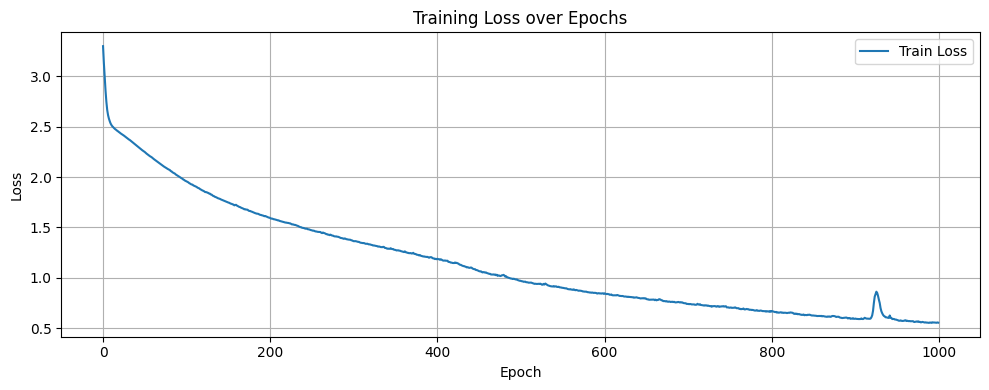

In [33]:
plt.figure(figsize=(10, 4))
plt.plot(loss_history, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [34]:
from IPython.display import Audio, display

def load_model_for_inference(model_path="lstm_speech_model.pth"):
    model = LSTMModel().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def infer_and_play_audio(sample_path, label_text=None, model_path="lstm_speech_model.pth"):
    print(f"[음성 재생]: {sample_path}")
    display(Audio(sample_path))

    model = load_model_for_inference(model_path)
    mfcc = extract_mfcc(sample_path)
    x = torch.tensor(mfcc, dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(x)
        pred_idx = output.argmax(2)[0]
        pred_text = ''.join([idx2char[i.item()] for i in pred_idx if i.item() != PAD_IDX])

    if label_text:
        print("[정답 문장]:", label_text)
    print("[모델 예측]:", pred_text)

In [35]:
sample_path, label = samples[3]
infer_and_play_audio(sample_path, label_text=label)

[음성 재생]: gsc_concat/sample_3.wav


[정답 문장]: zero zero one four zero
[모델 예측]: zero zero one four zero zroooooo foreethre weee eo werrteworeohee fir zthereeee eeeeeeee  hrretteehh
